In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['figure.dpi'] = 80
# matplotlib.rcParams['figure.figsize'] = [17, 4]
matplotlib.rcParams['axes.grid'] = True

In [2]:
# !pip install --upgrade pip --proxy=https://web-proxy.labs.hpecorp.net:8088
import sys
sys.version_info

sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)

In [3]:
import sys
sys.path.insert(0, '../')

from lib_data import *
from lib_nn_dpe import NN_dpe

In [4]:
load_workspace(vars(), '../data/20190821-051552-mnist_xs')
load_workspace(vars(), '../data/20200130-100802-mnist_config')

c:\users\canli\.venv\py37\lib\site-packages\dill\_dill.py:473: UserWarning: This figure was saved with matplotlib version 3.1.1 and is unlikely to function correctly.
  obj = StockUnpickler.load(self)


Loaded: In, Out, weights, train_images, train_labels, test_images, test_labels, g, img_idx, image, vectors, outputs, software, c, x, y, mat_contents, finalGconv, g1, g2, linear_factors_conv, xs, acc, result, x1, 
Loaded: xs, new_lin_cor_fc1, new_lin_cor_fc2, lin_cor_conv, finalGfc, finalGconv, weights, 


In [5]:
del train_images
del train_labels
# del test_images
# del test_labels
del xs

In [6]:
from lib_ecc import *

## Construct NN

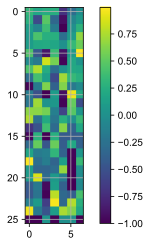

In [7]:
nn = NN_dpe(weights)
nn.Gratio = 100e-6
plt.imshow(nn.Mconv); plt.colorbar()

## ECC matrix

7 4.0 7.0
The number of redundancy column is chosen to be the smallest even number 8
(26, 15)


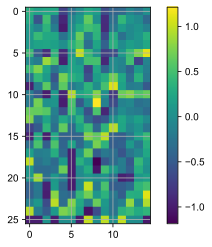

In [8]:
from dpeECC import dpeECC

delta = 1
Delta = 8 * delta

m = nn.Mconv.shape[0]
k = nn.Mconv.shape[1]

print(k, np.ceil(np.sqrt(k+1))+1, 2*k/(np.floor(Delta/(2*delta))-2))

ecc = dpeECC(nn.Mconv, delta, Delta)
M_conv_ecc = ecc.encode()

print('The number of redundancy column is chosen to be the smallest even number', ecc.r)
print(M_conv_ecc.shape)

plt.imshow(M_conv_ecc); plt.colorbar()

Convert to conductance

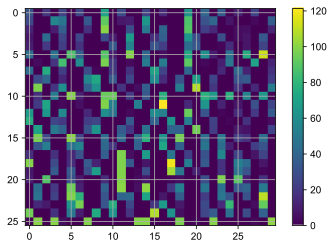

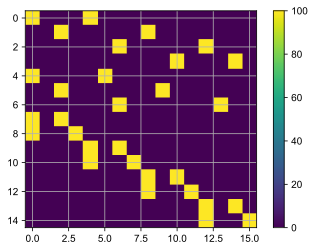

In [9]:
G_conv_ecc = weight2conductance(M_conv_ecc)
G_parity_ecc = weight2conductance(ecc.H.T)

plt.figure(1)
plt.imshow(G_conv_ecc * 1e6); plt.colorbar()

plt.figure(2)
plt.imshow(G_parity_ecc * 1e6); plt.colorbar()

# Load the data

In [11]:
# dir_data = '/Volumes/T7 Touch/SuperT/' # mac
dir_data = 'X:/SuperT/'

# load_workspace(vars(), filename=dir_data + '20200624-081921-multi-gain-repeat-all')
load_workspace(vars(), filename=dir_data + '20200624-104107-cnn-accuracy-delta1')

Loaded: In, Out, y1_list, cnn_y1_list, delta_list, acc_list, delta, Delta, weights, train_images, train_labels, test_images, test_labels, g, img_idx, image, vectors, outputs, software, c, x, y, mat_contents, finalGconv, g1, g2, linear_factors_conv, xs, acc, result, x1, y_pred, y1, k, new_lin_cor_fc1, new_lin_cor_fc2, lin_cor_conv, finalGfc, 


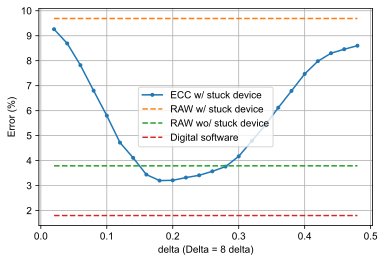

In [12]:
plt.plot(delta_list, [100-acc for acc in acc_list], '.-', label='ECC w/ stuck device')

plt.plot(delta_list, [100-90.31 for _ in delta_list], '--', label='RAW w/ stuck device')
plt.plot(delta_list, [100-96.21 for _ in delta_list], '--', label='RAW wo/ stuck device')
plt.plot(delta_list, [100-98.20 for _ in delta_list], '--', label='Digital software')

plt.xlabel('delta (Delta = 8 delta)')
plt.ylabel('Error (%)')
# plt.yscale('log')
plt.legend()

In [13]:
np.array(cnn_y1_list).shape

(10000, 400, 15)

In [14]:
delta = 0.2
    
Delta = 8 * delta
ecc = dpeECC(nn.Mconv, delta, Delta)

y_pred = []

y1_soft_list = []
y1_ecc_list = []

for img, y1 in tqdm( zip(test_images, cnn_y1_list ), total=len(test_images)):
# for y1 in tqdm(cnn_y1_list, total=len(test_labels)):
    vectors = nn._conv_flattern(img)
    output_soft = vectors.T @ G_conv_ecc / nn.Gratio
    y1_soft = output_soft[:, ::2] - output_soft[:, 1::2]
    y1_soft_list.append(y1_soft.copy())

    y1_ecc = correct_ecc(y1.copy(), ecc)
    y1_ecc_list.append(y1_ecc.copy())
    k = nn.Gconv.shape[1] //2

    # Remaining layer
    y_pred.append(dense(y1_ecc[:, :k], nn, finalGfc))

acc = np.mean(y_pred==test_labels)*100
print(f"delta={delta}, Accuracy={acc:.2f}%")

100%|███████████████████████████████████████████████████████| 10000/10000 [02:38<00:00, 63.12it/s]

delta=0.2, Accuracy=96.79%


In [20]:
N_IMG = 10


y1_raw = np.array(cnn_y1_list[:N_IMG]).reshape(-1, 15)
y1_soft = np.array(y1_soft_list[:N_IMG]).reshape(-1, 15)
y1_ecc = np.array(y1_ecc_list[:N_IMG]).reshape(-1, 15)

y1_raw.shape, y1_soft.shape, y1_ecc.shape

((4000, 15), (4000, 15), (4000, 15))

(-2.0, 2.0)

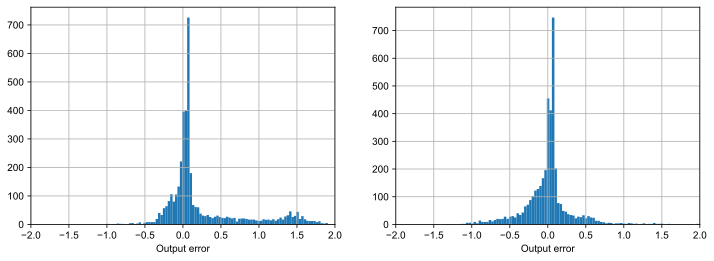

In [21]:
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)

_ = plt.hist((y1_raw - y1_soft)[:,0].reshape(-1), 100)
plt.xlabel('Output error')
# plt.yscale('log')
plt.xlim((-2,2))

plt.subplot(1,2,2)
_ = plt.hist((y1_ecc - y1_soft)[:,0].reshape(-1), 100)
plt.xlabel('Output error')
# plt.yscale('log')
plt.xlim((-2,2))

In [22]:
delta_list = np.arange(0.02, 0.5, 0.02)

y1_ecc_list_list = []

for delta in tqdm(delta_list):
    y1_ecc = []
    
    Delta = 8 * delta
    ecc = dpeECC(nn.Mconv, delta, Delta)

#     for y1_raw in y1_raw_list:
    y1_ecc = correct_ecc(y1_raw, ecc)
#     y1_ecc.append( correct_ecc(y1_raw, ecc) )
        
    y1_ecc_list_list.append(y1_ecc)

100%|█████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 14.26it/s]


In [23]:
y1_ecc.shape

(4000, 15)

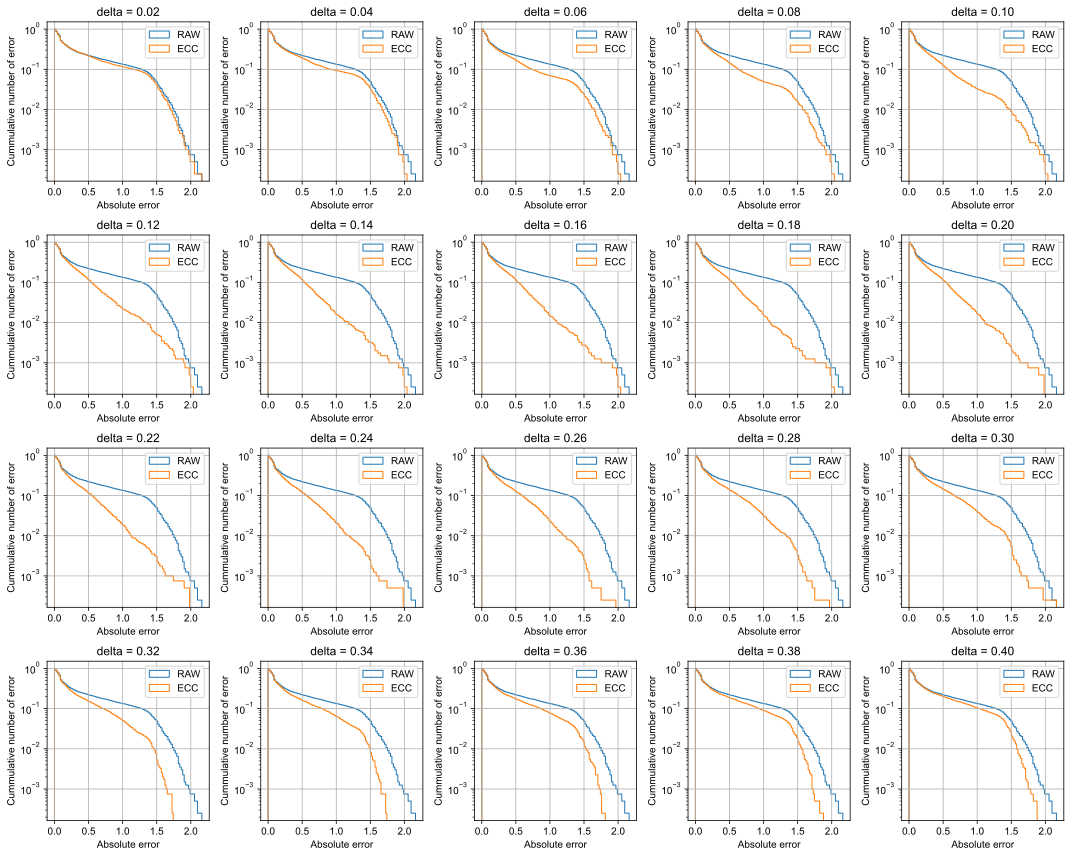

In [24]:
# output_soft = vectors.T @ G_conv_ecc / nn.Gratio
# y1_soft = output_soft[:, ::2] - output_soft[:, 1::2]

plt.figure(figsize=(15,12))

# for i in range(len(y1_list)):
for i in range(20):
    
    plt.subplot(4,5,i+1)

#     y1_raw = y1_raw_list[0]
    y1_ecc = y1_ecc_list_list[i]

    err_raw = (y1_raw - y1_soft)[:,0].reshape(-1)
    err_ecc = (y1_ecc - y1_soft)[:,0].reshape(-1)


    _ = plt.hist(abs(err_raw), density=True, histtype='step', cumulative=-1,
            label='RAW', bins=100)

    _ = plt.hist(abs(err_ecc), density=True, histtype='step', cumulative=-1,
            label='ECC', bins=100)

    plt.legend()

    plt.yscale('log')
    plt.xlabel('Absolute error')
    plt.ylabel('Cummulative number of error')
    
    plt.title(f'delta = {delta_list[i]:.2f}')
    
plt.tight_layout()

1.1461539850871123
0.9172110683768122
0.7337952346404834
0.6318975492314118
0.5706928719857338
0.5503124173205829
0.529931962655432
0.5299998638223402
0.5503794009041546
0.5550590615745159
0.5550590615745159
0.5748778887844926
0.5903940276868976
0.6297448362196796
0.6704537515086016
0.7144912479042282
0.7841848428514536
0.8700820511105333
0.9397876182282061
1.03375319008151


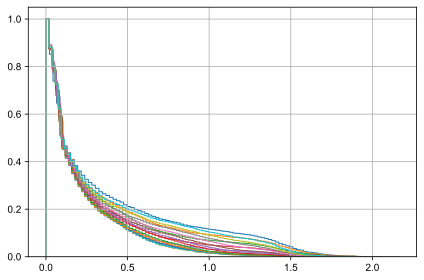

In [25]:
# output_soft = vectors.T @ G_conv_ecc / nn.Gratio
# y1_soft = output_soft[:, ::2] - output_soft[:, 1::2]

# plt.figure(figsize=(12,15))

th_list = []
# for i in range(len(y1_list)):
for i in range(20):
    
    y1_ecc = y1_ecc_list_list[i]

    err_ecc = (y1_ecc - y1_soft)[:,0].reshape(-1)

    a = plt.hist(abs(err_ecc), density=True, histtype='step', cumulative=-1,
            label='ECC', bins=100)
    
    th = a[1][(a[0]<0.1).argmax()]
    print(th)
    th_list.append(th)

    
plt.tight_layout()

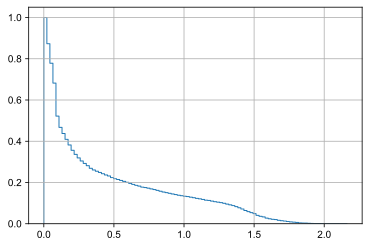

In [26]:
a = plt.hist(abs(err_raw), density=True, histtype='step', cumulative=-1,
            label='RAW', bins=100)

In [27]:
a[1][(a[0]<0.1).argmax()]

1.2759057466949288

Text(0, 0.5, '10% Error')

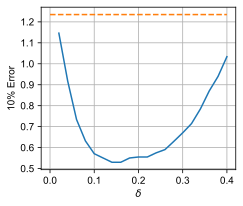

In [30]:
plt.figure(figsize=(3.5,3))

plt.plot(delta_list[:20], th_list)
plt.plot([0, 0.4], [1.2348514969629136, 1.2348514969629136], '--')
plt.xlabel('$\delta$')
plt.ylabel('10% Error')

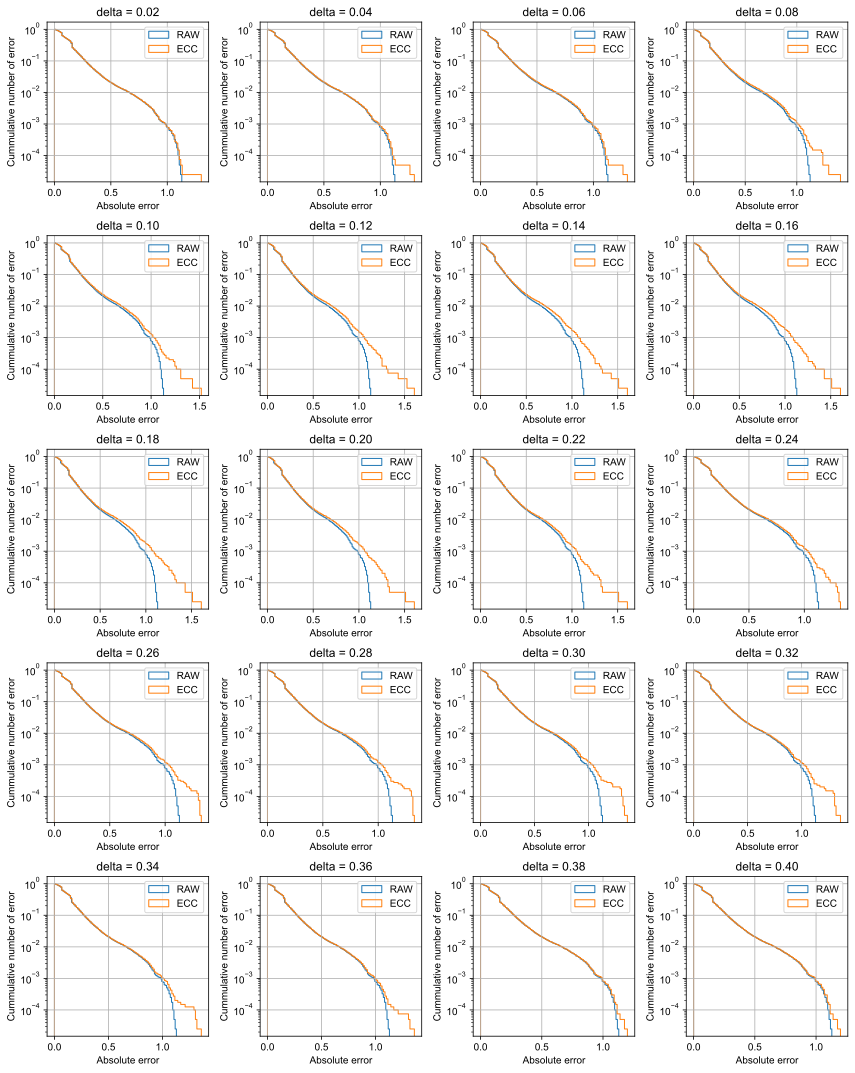

In [68]:
# output_soft = vectors.T @ G_conv_ecc / nn.Gratio
# y1_soft = output_soft[:, ::2] - output_soft[:, 1::2]

plt.figure(figsize=(12,15))

# for i in range(len(y1_list)):
for i in range(20):
    
    plt.subplot(5,4,i+1)

#     y1_raw = y1_raw_list[0]
    y1_ecc = y1_ecc_list_list[i]


    err_raw = (y1_raw - y1_soft)[:,1].reshape(-1)
    err_ecc = (y1_ecc - y1_soft)[:,1].reshape(-1)


    _ = plt.hist(abs(err_raw), density=True, histtype='step', cumulative=-1,
            label='RAW', bins=100)

    _ = plt.hist(abs(err_ecc), density=True, histtype='step', cumulative=-1,
            label='ECC', bins=100)

    plt.legend()

    plt.yscale('log')
    plt.xlabel('Absolute error')
    plt.ylabel('Cummulative number of error')
    
    plt.title(f'delta = {delta_list[i]:.2f}')
    
plt.tight_layout()